###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c) 2019 Daniel Koehn, based on (c)2018 L.A. Barba, G.F. Forsyth [CFD Python](https://github.com/barbagroup/CFDPython#cfd-python), (c)2014 L.A. Barba, I. Hawke, B. Knaepen [Practical Numerical Methods with Python](https://github.com/numerical-mooc/numerical-mooc#practical-numerical-methods-with-python), also under CC-BY.

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# 2D Linear Advection-Diffusion Equation

After solving the 2D linear advection problem in the [last notebook](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/08_Convection_2D/02_2D_Linear_Advection.ipynb), we have to add the diffusion equation to the problem. The resulting 2D advection-diffusion equation can be solved by separating the diffusion from the advection problem using operator splitting and applying the Marker-in-Cell method to the advection problem, while the diffusion problem is solved by finite-differences.

## 2D Linear Advection-Diffusion Problem

The linear 2D heat advection-diffusion equation reads:

\begin{equation}
\frac{\partial T}{\partial t} + v_x \frac{\partial T}{\partial x} + v_z \frac{\partial T}{\partial z}= \kappa \biggl(\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial z^2}\biggl), \tag{1}
\end{equation}

where $T$ denotes the 2D temperature field, $v_x, v_z$ the components of the velocity field in x- and z-direction, respectively and $\kappa$ the thermal diffusivity.

We can split the problem into an advection and diffusion part using **operator splitting** and introducing forward FD-operators for the time derivatives

\begin{equation}
\begin{split}
\frac{T^{n+1/2}_{i,j}-T^{n}_{i,j}}{\Delta t/2} &= - v_x \frac{\partial T^n}{\partial x} - v_z \frac{\partial T^n}{\partial z}\\
\frac{T^{n+1}_{i,j}-T^{n+1/2}_{i,j}}{\Delta t/2} &= \kappa \biggl(\frac{\partial^2 T^{n+1/2}}{\partial x^2} + \frac{\partial^2 T^{n+1/2}}{\partial z^2}\biggl),
\end{split}
\notag
\end{equation}

Notice, that we first update the temperature field using the advection equation by half a time step $\Delta t /2$ and use the new temperature field $T^{n+1/2}$ at time step $n+1/2$ to solve the 2D diffusion equation. 

As discussed in [the previous notebook](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/08_Convection_2D/02_2D_Linear_Advection.ipynb) the 2D advection problem can be solved by the **Marker-in-Cell method**. To solve the diffusion part, we can replace the second spatial deriviatives on the RHS of the diffusion problem using the central FD scheme, leading to 

\begin{equation}
\frac{T^{n+1}_{i,j} - T^{n+1/2}_{i,j}}{\Delta t/2} = \kappa \left( \frac{T^{n+1/2}_{i+1, j} - 2T^{n+1/2}_{i,j} + T^{n+1/2}_{i-1,j}}{\Delta x^2} + \frac{T^{n+1/2}_{i, j+1} - 2T^{n+1/2}_{i,j} + T^{n+1/2}_{i,j-1}}{\Delta y^2}\right)\notag
\end{equation}

Rearranging the equation to solve for the value at the next time step $T^{n+1}_{i,j}$, yields the **Forward-in-Time-Central-in-Space (FTCS)** finite difference method

\begin{equation}
T^{n+1}_{i,j}= T^{n+1/2}_{i,j} + \kappa \left( \frac{\Delta t/2}{\Delta x^2} (T^{n+1/2}_{i+1, j} - 2T^{n+1/2}_{i,j} + T^{n+1/2}_{i-1,j}) + \\\frac{\Delta t/2}{\Delta y^2} (T^{n+1/2}_{i, j+1} - 2T^{n+1/2}_{i,j} + T^{n+1/2}_{i,j-1})\right)\tag{2}
\end{equation}

which we already studied in [lecture 6](https://github.com/daniel-koehn/Differential-equations-earth-system/tree/master/06_Heat_2D#differential-equations-in-earth-sciences-2d-heat-equation). Lets combine the Marker-in-Cell method to solve the advection problem with the FTCS method to solve the diffusion problem. 

As usual, we start by importing some libraries:

In [2]:
# Import libraries
import numpy
from matplotlib import pyplot
%matplotlib inline
from scipy import interpolate

In [3]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

Next, we write a function `update_diff_2D` to update the 2D diffusion equation using the FTCS method eq. (2).

In [4]:
def update_diff_2D(T, sigma_x, sigma_z, nx, nz):
    
    # store old temperature field
    Tn = T.copy()
        
    # loop over spatial grid 
    for i in range(1,nx-1):
        for j in range(1,nz-1):
                
            T[j, i] = (Tn[j, i] +
                        sigma_x * (Tn[j, i+1] - 2.0 * Tn[j, i] + Tn[j, i-1]) +
                        sigma_z * (Tn[j+1, i] - 2.0 * Tn[j, i] + Tn[j-1, i]))
            
    return T            

In order to combine the advection with the diffusion problem, we take our Marker-in-Cell code `Adv_2D` from the [previous notebook](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/08_Convection_2D/02_2D_Linear_Advection.ipynb), rename it to `Adv_diff_2D` and include the `update_diff_2D` function to incorporate the diffusion problem: 

In [5]:
# Marker-in-cell code to solve the 2D advection equation
# ------------------------------------------------------
def Adv_diff_2D(T0, nt, dt, dx, dz, Vx, Vz, Lx1, Lx2, Lz1, Lz2, x, z, X, Z, alpha):
    """
    Computes and returns the temperature distribution
    after a given number of time steps for the 2D advection 
    problem. A marker-in-cell approach with Dirichlet conditions 
    on all boundaries is used in order to mitigate the effect of 
    numerical diffusion.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 2D array of floats.
    nt : integer
        Maximum number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Grid spacing in the x direction.
    dz : float
        Grid spacing in the z direction.
    Vx : float
        x-component of the velocity field.
    Vz : float
        z-component of the velocity field.        
    Lx1, Lx2 : float
        Model extension from Lx1 - Lx2.
    Lz1, Lz2 : float
        Model extension from Lz1 - Lz2.
    x, z : float
        Model coordinates as 1D arrays.
    X, Z : float
        Model coordinates as 2D arrays.    
        
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 2D array of floats.
    """

    # Integrate in time.
    T = T0.copy()
    
    # Estimate number of grid points in x- and z-direction
    nz, nx = T.shape
    
    # Define number of markers and initial marker positions
    nx_mark = 4 * nx  # number of markers in x-direction
    nz_mark = 4 * nz  # number of markers in z-direction    
    
    # Define some constants.
    sigma_x = alpha * dt / dx**2
    sigma_z = alpha * dt / dz**2
    
    # Time loop
    for n in range(nt):        
                
        # initial marker positions
        x_mark = numpy.linspace(Lx1, Lx2, num=nx_mark)
        z_mark = numpy.linspace(Lz1, Lz2, num=nz_mark)
        X_mark, Z_mark = numpy.meshgrid(x_mark,z_mark)
        
        # Interpolate velocities from grid to marker position at timestep n        
        f = interpolate.interp2d(x, z, Vx, kind='linear')
        vx_mark_n = f(x_mark, z_mark)
        
        f = interpolate.interp2d(x, z, Vz, kind='linear')
        vz_mark_n = f(x_mark, z_mark)
        
        # Interpolate temperature from grid to marker position at timestep n
        f = interpolate.interp2d(x, z, T, kind='cubic')
        T_mark = f(x_mark, z_mark)
        
        # Save current marker positions
        X0 = X_mark
        Z0 = Z_mark
        
        # Update marker position
        X_mark = X_mark + vx_mark_n * dt
        Z_mark = Z_mark + vz_mark_n * dt
        
        # Interpolate velocities from grid to marker position at timestep n+1 
        vx_mark_n1 = interpolate.griddata((X.flatten(), Z.flatten()), Vx.flatten(), (X_mark, Z_mark), method='linear')
        vz_mark_n1 = interpolate.griddata((X.flatten(), Z.flatten()), Vz.flatten(), (X_mark, Z_mark), method='linear')
        
        # Replace Nan values 
        mask = numpy.where(numpy.isnan(vx_mark_n1))
        vx_mark_n1[mask] = 0
        
        mask = numpy.where(numpy.isnan(vz_mark_n1))
        vz_mark_n1[mask] = 0
        
        # Update marker position with midpoint velocity
        X_mark = X0 + dt * (vx_mark_n + vx_mark_n1) / 2.
        Z_mark = Z0 + dt * (vz_mark_n + vz_mark_n1) / 2.

        # Interpolate temperature field from marker to grid positions
        T = interpolate.griddata((X_mark.flatten(), Z_mark.flatten()), T_mark.flatten(), (X, Z), method='cubic')
        
        # Replace Nan-values by old temperature field 
        mask = numpy.where(numpy.isnan(T))
        T[mask] = T0[mask]
        
        # Update diffusion equation
        T = update_diff_2D(T, sigma_x, sigma_z, nx, nz)
        
    return T

Well, and here we have our 2D advection-diffusion code. That was quite easy to implement. Time to test, if the new code is working correctly.

## Temperature Advection-Diffusion in boring velocity field $V = (Z,-X)$

After implementing the code to solve the 2D linear advection-diffusion problem, let 's define some modelling parameters and initial spatial Gaussian temperature distribution

\begin{equation}
T_0 = A_0\; exp\biggl(-\frac{(x+x_{\text{shift}})^2+z^2}{\sigma^2}\biggr) \notag
\end{equation}

on the domain $x \in \{-0.5,0.5\},\; z \in \{-0.5,0.5\}$ with amplitude $A_0 = 2$, shift in x-direction $x_{\text{shift}} = 0.25$ and half-width $\sigma = 0.1$.  

To advect the temperature, a velocity field is required. We start with the "boring" velocity field $V = (Z,-X)$ from the [How to sail without wind exercise](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/02_finite_difference_intro/3_fd_ODE_example_sailing_wo_wind.ipynb):

In [6]:
# Definition of modelling parameters
# ----------------------------------
Lx = 0.5  # half-length of the model in x direction [m]
Lz = 0.5  # half-height of the model in z direction [m]
nx = 41   # number of points in the x direction
nz = 41   # number of points in the z direction
dx = 2 * Lx / (nx - 1)  # grid spacing in the x direction
dz = 2 * Lz / (nz - 1)  # grid spacing in the z direction
alpha = 1e-3 # thermal diffusivity

# Define the locations along a gridline.
x = numpy.linspace(-Lx, Lx, num=nx)
z = numpy.linspace(-Lz, Lz, num=nz)

# Define the initial temperature distribution as Gaussian function
X, Z = numpy.meshgrid(x,z) # coordinates X,Z required to define T0

sigma = 0.1
amp = 2.
xshift = 0.25

# initial temperature distribution
T0 = amp * numpy.exp(-((X + xshift)**2 + Z**2) / sigma**2.) 

# Define velocity field (Vx,Vz)
Vx = Z
Vz = - X

Let's check if the initial temperature distribution and velocity field are correctly implemented.

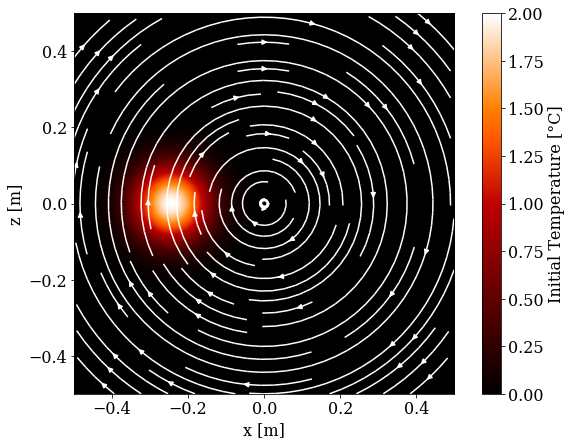

In [7]:
# Plot the initial temperature distribution and streamlines
pyplot.figure(figsize=(10.0, 7))

extent = [numpy.min(x), numpy.max(x),numpy.min(z), numpy.max(z)]
cmap = 'gist_heat'
im = pyplot.imshow(numpy.flipud(T0), extent=extent, interpolation='spline36', cmap=cmap)
stream = pyplot.streamplot(X,Z,Vx,Vz,color='w')

pyplot.xlabel('x [m]')
pyplot.ylabel('z [m]')
cbar = pyplot.colorbar(im)
cbar.set_label('Initial Temperature [°C]')

Looks correct, so finally we define the timestep `dt` and the number of time steps `nt` we want to advect the temperature field and run the `Adv_diff_2D` code

In [8]:
# Set the time-step size
dt = 2.5e-2  # time-step size [s]
nt = 50      # number of time steps to compute

# Compute the temperature distribution after nt timesteps
T = Adv_diff_2D(T0, nt, dt, dx, dz, Vx, Vz, -Lx, Lx, -Lz, Lz, x, z, X, Z,alpha)

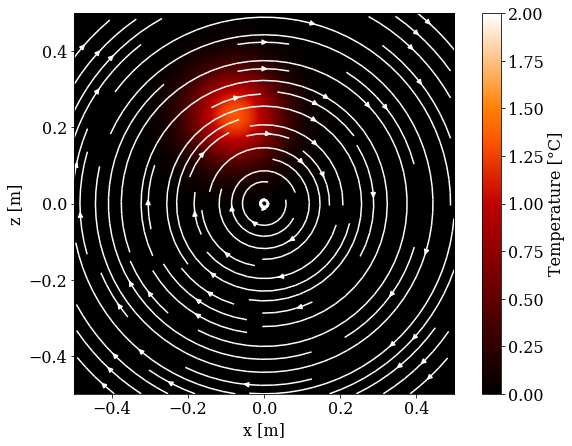

In [9]:
# Plot the temperature distribution and streamlines
pyplot.figure(figsize=(10.0, 7))

extent = [numpy.min(x), numpy.max(x),numpy.min(z), numpy.max(z)]
cmap = 'gist_heat'
im = pyplot.imshow(numpy.flipud(T), extent=extent, interpolation='spline36', 
                   cmap=cmap, aspect=1, vmin=numpy.min(T0), vmax=numpy.max(T0))
stream = pyplot.streamplot(X,Z,Vx,Vz,color='w')

pyplot.xlabel('x [m]')
pyplot.ylabel('z [m]')
cbar = pyplot.colorbar(im)
cbar.set_label('Temperature [°C]')

Notice how the temperature anomaly is advected in the velocity field, while heat is transported by conduction (diffusion), leading to a spreading of the temperature anomaly in all directions and a decrease of it 's amplitude. This becomes more obvious when visualizing the 2D advection-diffusion in the following movie, where the number of time steps is increased to `nt=400`:

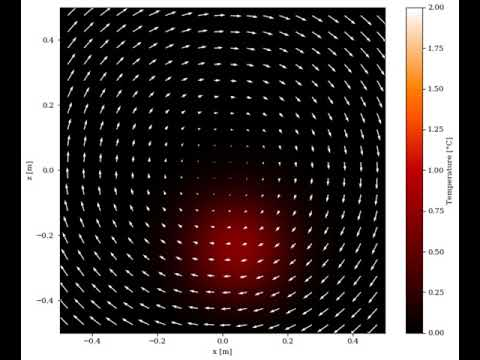

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo('yNT9-ht2HRE')

## What we learned:

* How to extent the 2D Marker-in-Cell advection code in order to solve the advection-diffusion problem

* Computed 2D advection-diffusion of a Gaussian temperature distribution in a simple velocity field, where the anomaly is advected in the velocity field and heat transported by heat conduction (diffusion)